## Assignment:

Beat the performance of my Lasso regression by **using different feature engineering steps ONLY!!**.

The performance of my current model, as shown in this notebook is:
- test rmse: 44798.497576784845
- test r2: 0.7079639526659389

To beat my model you will need a test r2 bigger than 0.71 and a rmse smaller than 44798.


### Conditions:

- You MUST NOT change the hyperparameters of the Lasso.
- You MUST use the same seeds in Lasso and train_test_split as I show in this notebook (random_state)
- You MUST use all the features of the dataset (except Id) - you MUST NOT select features


### If you beat my model:

Make a pull request with your notebook to this github repo:
https://github.com/solegalli/udemy-feml-challenge

Remember that you need to fork this repo first, upload your winning notebook to your repo, and then make a PR to my repo. This way, other students can learn from your creativity when transforming the variables in your dataset. 

### MY Results

The performance of the model is:

- test rmse: 38878.26693241943
- test r2: 0.7800503081482318

### Changes Made

- Log transformation of variables: "1stFlrSF","GrLivArea","LotFrontage"]
- yeo-jhonson transformation of variables:  "BsmtFinSF1","OpenPorchSF","TotalBsmtSF"
-   Discretize variables: "3SsnPorch","BsmtFinSF2","EnclosedPorch","LotArea","LowQualFinSF","MiscVal","ScreenPorch""MasVnrArea","WoodDeckSF"

## House Prices dataset

In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# for the model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# for feature engineering
from sklearn.preprocessing import StandardScaler
from feature_engine import missing_data_imputers as mdi
from feature_engine import discretisers as dsc
from feature_engine import categorical_encoders as ce
from feature_engine import variable_transformers as vt

### Load Datasets

In [2]:
# load dataset

data = pd.read_csv("train_house_price.csv")

In [3]:
# make lists of variable types

categorical = [var for var in data.columns if data[var].dtype == 'O']

year_vars = [var for var in data.columns if 'Yr' in var or 'Year' in var]

discrete = [
    var for var in data.columns if data[var].dtype != 'O'
    and len(data[var].unique()) < 20 and var not in year_vars
]

numerical = [
    var for var in data.columns if data[var].dtype != 'O'
    if var not in discrete and var not in ['Id', 'SalePrice']
    and var not in year_vars
]

print('There are {} continuous variables'.format(len(numerical)))
print('There are {} discrete variables'.format(len(discrete)))
print('There are {} temporal variables'.format(len(year_vars)))
print('There are {} categorical variables'.format(len(categorical)))

There are 18 continuous variables
There are 14 discrete variables
There are 4 temporal variables
There are 43 categorical variables


### Separate train and test set

In [4]:
# IMPORTANT: keep the random_state to zero for reproducibility
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(data.drop(
    ['Id', 'SalePrice'], axis=1),
    data['SalePrice'],
    test_size=0.1,
    random_state=0)

In [5]:
# calculate elapsed time

def elapsed_years(df, var):
    # capture difference between year variable and
    # year the house was sold
    
    df[var] = df['YrSold'] - df[var]
    return df

for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    X_train = elapsed_years(X_train, var)
    X_test = elapsed_years(X_test, var)

In [6]:
# drop YrSold
X_train.drop('YrSold', axis=1, inplace=True)
X_test.drop('YrSold', axis=1, inplace=True)

In [7]:
# capture the column names for use later in the notebook
final_columns = X_train.columns

#### Numerical variables

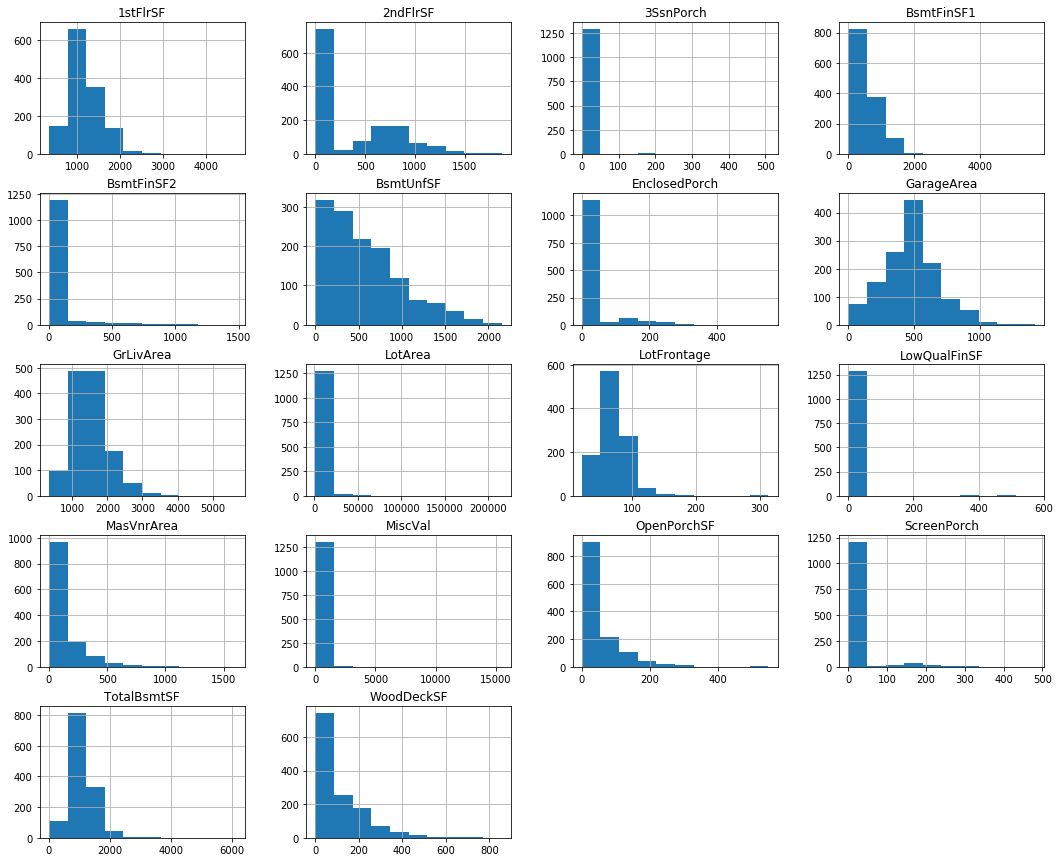

In [8]:
# histograms of the numerical variables
X_train[numerical].hist(figsize = (18,15))
plt.show()

In [9]:
# From the histogram plots selecting extremley skewed variables to be discetized
var_to_discretize = ["3SsnPorch","BsmtFinSF2","EnclosedPorch","LotArea","LowQualFinSF","MiscVal","ScreenPorch"]

## For rest of the variable we will check if log transformation makes them gaussian distributed
var_to_log_transform = ["1stFlrSF","BsmtFinSF1","GrLivArea","LotFrontage","MasVnrArea","OpenPorchSF","TotalBsmtSF","WoodDeckSF"]

C:\Users\abyanjan.FSE17-32\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


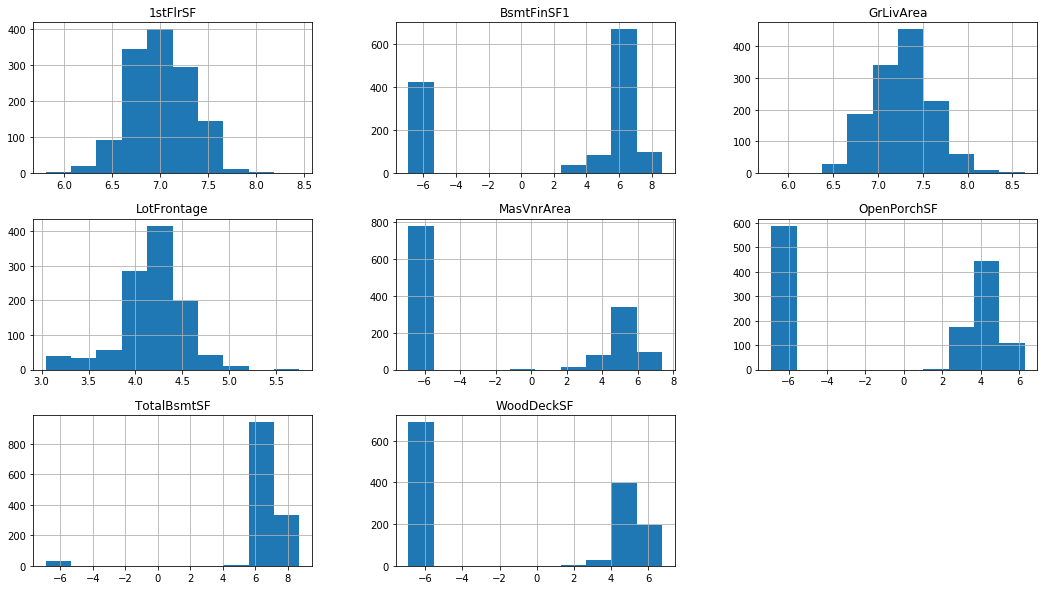

In [10]:
# checking the results of log transformation
log_df = X_train[var_to_log_transform]

for var in var_to_log_transform:
    log_df[var] = np.log(log_df[var]+0.001)
    
log_df.hist(figsize = (18,10))
plt.show()

Log Transformation only worked good for three of the variable, so for rest of the varibles we will try yeo-johnson transformation

In [11]:
var_to_log_transform = ["1stFlrSF","GrLivArea","LotFrontage"]

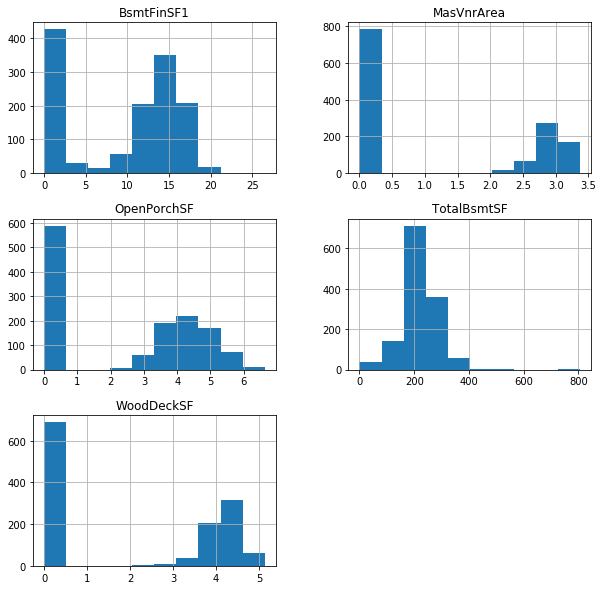

In [12]:
# Yeo-johnson Transormation
var_to_yj_transform = ["BsmtFinSF1","MasVnrArea","OpenPorchSF","TotalBsmtSF","WoodDeckSF"]

from sklearn.preprocessing import  PowerTransformer
YJ = PowerTransformer(method = 'yeo-johnson', standardize = False)
yj_data = X_train[var_to_yj_transform]
yj_data = YJ.fit_transform(yj_data)

yj_data = pd.DataFrame(yj_data, columns=var_to_yj_transform)
yj_data.hist(figsize = (10,10))
plt.show()

With yeo-johnson transformation "BsmtFinSF1","OpenPorchSF","TotalBsmtSF" have better distribution, but "MasVnrArea","WoodDeckSF" still look far from normal distribution. For noe we can leave them to be discretized

In [13]:
var_to_yj_transform = ["BsmtFinSF1","OpenPorchSF","TotalBsmtSF"]

var_to_discretize = var_to_discretize + ["MasVnrArea","WoodDeckSF"]

## Feature Engineering Pipeline

In [14]:
# I will treat discrete variables as if they were categorical
# to treat discrete as categorical using Feature-engine
# we need to re-cast them as object

X_train[discrete] = X_train[discrete].astype('O')
X_test[discrete] = X_test[discrete].astype('O')

In [15]:
house_pipe = Pipeline([

    # missing data imputation - section 4
    ('missing_ind',
     mdi.AddNaNBinaryImputer(
         variables=['LotFrontage', 'MasVnrArea', 'GarageYrBlt'])),
    
    ('imputer_num',
     mdi.MeanMedianImputer(
         imputation_method='median',
         variables=['LotFrontage', 'MasVnrArea', 'GarageYrBlt'])),
    
    # varaible transformation
    ('log_transform',
     vt.LogTransformer(variables=var_to_log_transform)),
    
    ('yj_transform',
    vt.YeoJohnsonTransformer(variables=var_to_yj_transform)),

    
    ('imputer_cat', mdi.CategoricalVariableImputer(variables=categorical)),
    
   
    # categorical encoding - section 6
    ('rare_label_enc',
     ce.RareLabelCategoricalEncoder(tol=0.05,
                                    n_categories=6,
                                    variables=categorical + discrete)),
    ('categorical_enc',
     ce.OrdinalCategoricalEncoder(encoding_method='ordered',
                                  variables=categorical + discrete)),
    

    # discretisation + encoding - section 8
    ('discretisation',
     dsc.EqualFrequencyDiscretiser(q=5,
                                   return_object=True,
                                   variables=var_to_discretize)),
    ('encoding',
     ce.OrdinalCategoricalEncoder(encoding_method='ordered',
                                  variables=var_to_discretize)),

    # feature Scaling - section 10
    ('scaler', StandardScaler()),

    # regression
    ('lasso', Lasso(random_state=0))
])

In [16]:
# let's fit the pipeline
house_pipe.fit(X_train, y_train)

# let's get the predictions
X_train_preds = house_pipe.predict(X_train)
X_test_preds = house_pipe.predict(X_test)

C:\Users\abyanjan.FSE17-32\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\abyanjan.FSE17-32\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\abyanjan.FSE17-32\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\abyanjan.FSE17-32\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [17]:
# check model performance:

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))

train mse: 909765436.9503471
train rmse: 30162.318162739863
train r2: 0.8542937326094231

test mse: 1511519639.668458
test rmse: 38878.26693241943
test r2: 0.7800503081482318


Text(0,0.5,'Predicted Price')

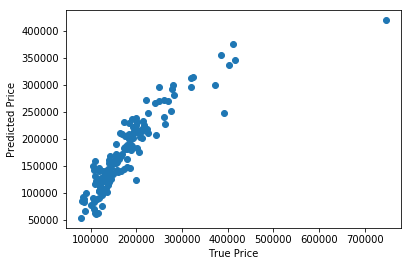

In [18]:
# plot predictions vs real value

plt.scatter(y_test,X_test_preds)
plt.xlabel('True Price')
plt.ylabel('Predicted Price')

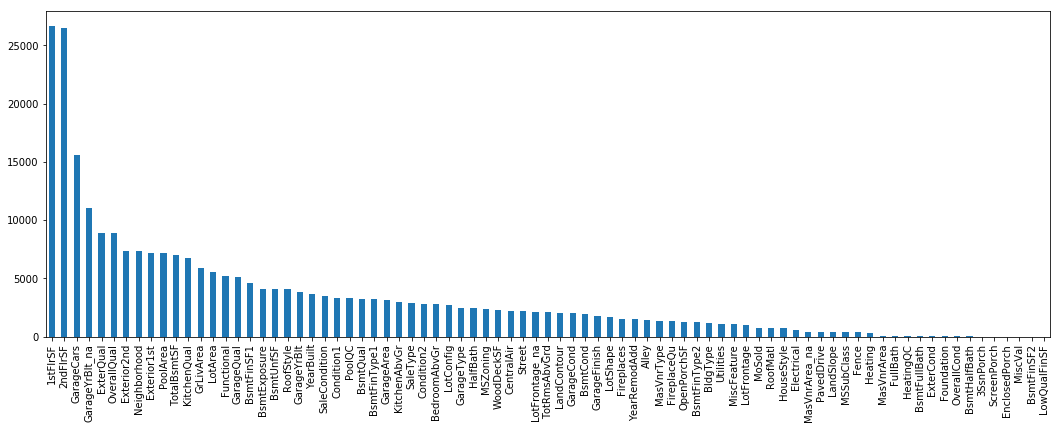

In [19]:
# let's explore the importance of the features
# the importance is given by the absolute value of the coefficient
# assigned by the Lasso

importance = pd.Series(np.abs(house_pipe.named_steps['lasso'].coef_))
importance.index = list(final_columns)+['LotFrontage_na', 'MasVnrArea_na',  'GarageYrBlt_na']
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(18,6))